In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso,SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score  , mean_absolute_error,make_scorer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostRegressor


2024-11-11 22:33:10.007 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
# We have mixed 2 datasets, top 1000 movies and worst rated 1000 movies to get our dataset.

In [3]:
df=pd.read_csv('data_new.csv')

# Basic data understanding and Data Cleaning

In [4]:
# Top 5 values
df.head(5)

,id,title,genres,averageRating,numVotes,releaseYear
0,tt0111161,The Shawshank Redemption,Drama,9.3,2958776,1994
1,tt0068646,The Godfather,"Crime, Drama",9.2,2062792,1972
2,tt0252487,The Chaos Class,Comedy,9.2,43660,1975
3,tt0259534,Ramayana: The Legend of Prince Rama,"Action, Adventure, Animation",9.2,15522,1993
4,tt16747572,The Silence of Swastika,"Documentary, History",9.1,10572,2021


In [5]:
# Bottom 5 values
df.tail(5)

,id,title,genres,averageRating,numVotes,releaseYear
1995,tt4334266,The Bad Batch,"Action, Horror, Mystery",5.2,36189,2016
1996,tt1712170,Alex Cross,"Action, Crime, Mystery",5.2,35725,2012
1997,tt0463872,Asterix at the Olympic Games,"Adventure, Comedy, Family",5.2,33127,2008
1998,tt1731697,The Lords of Salem,"Horror, Thriller",5.2,32998,2012
1999,tt13964390,Under Paris,"Action, Drama, Horror",5.2,32456,2024


In [6]:
# Columns
df.columns

Index(['id', 'title', 'genres', 'averageRating', 'numVotes', 'releaseYear'], dtype='object')

In [7]:
rows,columns=df.shape
print('The dataset has'+" "+str(rows)+" "+"rows")
print('The dataset has'+" "+str(columns)+" "+"columns")

The dataset has 2000 rows
The dataset has 6 columns


In [8]:
# Datatypes check
df.dtypes

id                object
title             object
genres            object
averageRating    float64
numVotes           int64
releaseYear        int64
dtype: object

In [9]:
# Each column has the correct data type.

In [10]:
# Data understanding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2000 non-null   object 
 1   title          2000 non-null   object 
 2   genres         2000 non-null   object 
 3   averageRating  2000 non-null   float64
 4   numVotes       2000 non-null   int64  
 5   releaseYear    2000 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 93.9+ KB


In [11]:
# Null values check
df.isnull().sum()

id               0
title            0
genres           0
averageRating    0
numVotes         0
releaseYear      0
dtype: int64

In [12]:
# No nulls in any of the columns.

In [13]:
missing_data = pd.DataFrame({'Total_Missing_Values': df.isnull().sum(), 'Percentage_Missing': (df.isnull().sum()/10000)*100})
missing_data

,Total_Missing_Values,Percentage_Missing
id,0,0.0
title,0,0.0
genres,0,0.0
averageRating,0,0.0
numVotes,0,0.0
releaseYear,0,0.0


In [14]:
# Duplicate check-
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


In [15]:
# There are no duplicates as well.

In [16]:
# Dropping the ID column as it has no importance in the prediction
df.drop('id',axis=1,inplace=True)

In [17]:
# 5 point summary
df.describe()

,averageRating,numVotes,releaseYear
count,2000.000000,2.000000e+03,2000.000000
mean,6.233300,1.560062e+05,2000.800000
std,2.011222,3.272965e+05,21.411451
min,1.000000,1.000800e+04,1920.000000
25%,4.600000,1.587250e+04,1994.000000
50%,6.500000,3.149700e+04,2007.000000
75%,8.100000,8.955175e+04,2016.000000
max,9.300000,2.958776e+06,2024.000000


In [18]:
# Findings-
# The average rating is approximately 6.23.
# The mean number of votes is around 156,006. This indicates that, on average, each movie has received a significant amount of votes.
# The average release year is approximately 2000.8, suggesting that this dataset includes movies predominantly from recent years, centered around the early 2000s
# A standard deviation of 2.01 indicates a moderate spread around the mean rating, meaning some movies are rated significantly higher or lower than the average
# With a large standard deviation (327,296.5), there's high variability in the number of votes. This suggests that some movies have received vastly more votes than others.
# A standard deviation of 21.4 years implies a moderate spread in movie release years, with most movies clustered around the late 20th and early 21st centurie
# The minimum rating is 1.0, and the maximum is 9.3, showing a broad range in movie quality according to ratings.
# numVotes:The minimum is 10,008, and the maximum is 2,958,776, indicating a large gap in popularity.
# releaseYear: The range spans from 1920 to 2024, covering over a century of movie releases.
# 25% of movies have a rating of 4.6 or lower, votes of about 15,872 or lower, and release years before 1994.
# The median rating is 6.5, indicating that half of the movies have a rating above this value. The median number of votes is around 31,497, and the median release year is 2007
# 75% of movies have a rating of 8.1 or lower, votes of around 89,551 or lower, and were released before 2016.

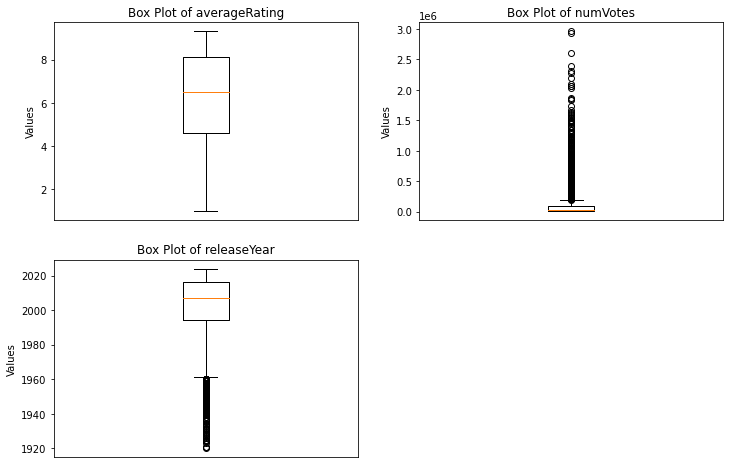

In [19]:
# Outliers check-
# Box plots for all numerical columns-
# Get numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Create subplots
num_cols = 2  
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axs = axs.flatten()  

# Create a box plot for each numerical column
for i, col in enumerate(numerical_cols):
    axs[i].boxplot(df[col])
    axs[i].set_title(f'Box Plot of {col}')
    axs[i].set_ylabel('Values')
    axs[i].set_xticks([])  
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

In [20]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column < lower_bound) | (column > upper_bound)).sum()


outlier_counts = df.select_dtypes(include=['float64', 'int64']).apply(count_outliers)

print("Outliers in each column:")
print(outlier_counts)

Outliers in each column:
averageRating      0
numVotes         340
releaseYear      156
dtype: int64


# EDA

In [21]:
# Finding the movie with the highest and lowest rating
highest_rated_movie = df.loc[df['averageRating'].idxmax(), ['title', 'averageRating']]
lowest_rated_movie = df.loc[df['averageRating'].idxmin(), ['title', 'averageRating']]

# Finding the movie with the highest and lowest number of votes
most_votes_movie = df.loc[df['numVotes'].idxmax(), ['title', 'numVotes']]
least_votes_movie = df.loc[df['numVotes'].idxmin(), ['title', 'numVotes']]

print("Highest Rated Movie:", highest_rated_movie)
print("Lowest Rated Movie:", lowest_rated_movie)
print("Movie with Most Votes:", most_votes_movie)
print("Movie with Fewest Votes:", least_votes_movie)

Highest Rated Movie: title            The Shawshank Redemption
averageRating                         9.3
Name: 0, dtype: object
Lowest Rated Movie: title            Reis
averageRating       1
Name: 1000, dtype: object
Movie with Most Votes: title       The Shawshank Redemption
numVotes                     2958776
Name: 0, dtype: object
Movie with Fewest Votes: title       Precious Cargo
numVotes             10008
Name: 1501, dtype: object


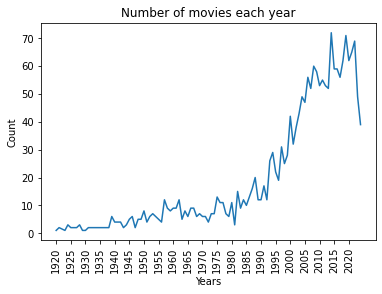

In [22]:
# How many movies release each year-
ax = sns.lineplot(data=df['releaseYear'].value_counts().sort_index())
tick_positions = range(min(df['releaseYear']), max(df['releaseYear']) + 1, 5)
ax.set_title("Number of movies each year")
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_positions, rotation = 90)
ax.set_xlabel("Years")
ax.set_ylabel("Count")
plt.show()

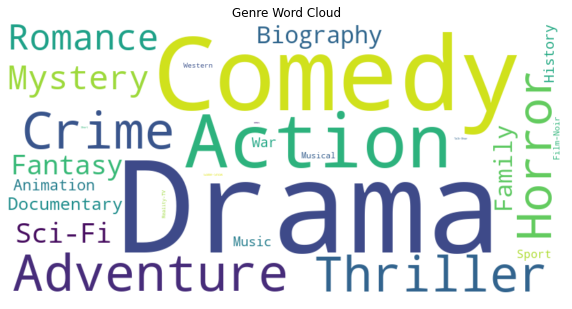

In [23]:
# World cloud of genre-
from wordcloud import WordCloud
genre_counts = df['genres'].str.split(', ', expand=True).stack().value_counts()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre Word Cloud')
plt.show()

In [24]:
# The movie releases follow an increasing trend. As years increases so do the number of movies in the dataset.

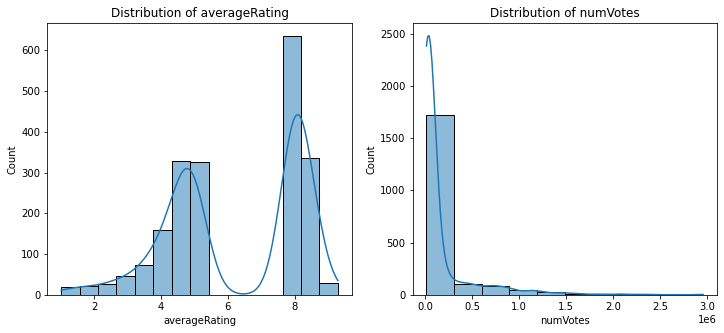

In [25]:
# Visualizing the distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['averageRating'], kde=True)
plt.title('Distribution of averageRating')

plt.subplot(1, 2, 2)
sns.histplot(df['numVotes'],bins=10, kde=True)
plt.title('Distribution of numVotes')

plt.show()

In [26]:
# The average ratings is has 2 peaks and no values between 6 and 7. This is because we have mixed the datasets of top 1000 and worst 1000 movies
# Num votes seems left skewed.

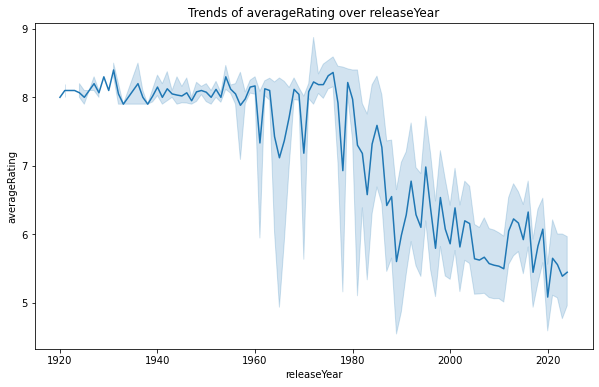

In [27]:
# analyzing the relationship between release year and average rating
plt.figure(figsize=(10, 6))
sns.lineplot(x='releaseYear', y='averageRating', data=df)
plt.title('Trends of averageRating over releaseYear')
plt.show()


In [28]:
#Movies from the 1920s through the 1960s have relatively high and consistent ratings, mostly around 7 to 8, with some minor fluctuations
# Between Late 1960s - 1980s: There is increased variability in ratings, with some movies rated much lower and others still rated highly. 
#  There appears to be a slight downward trend in average ratings over time, with older movies generally rated higher than newer ones.


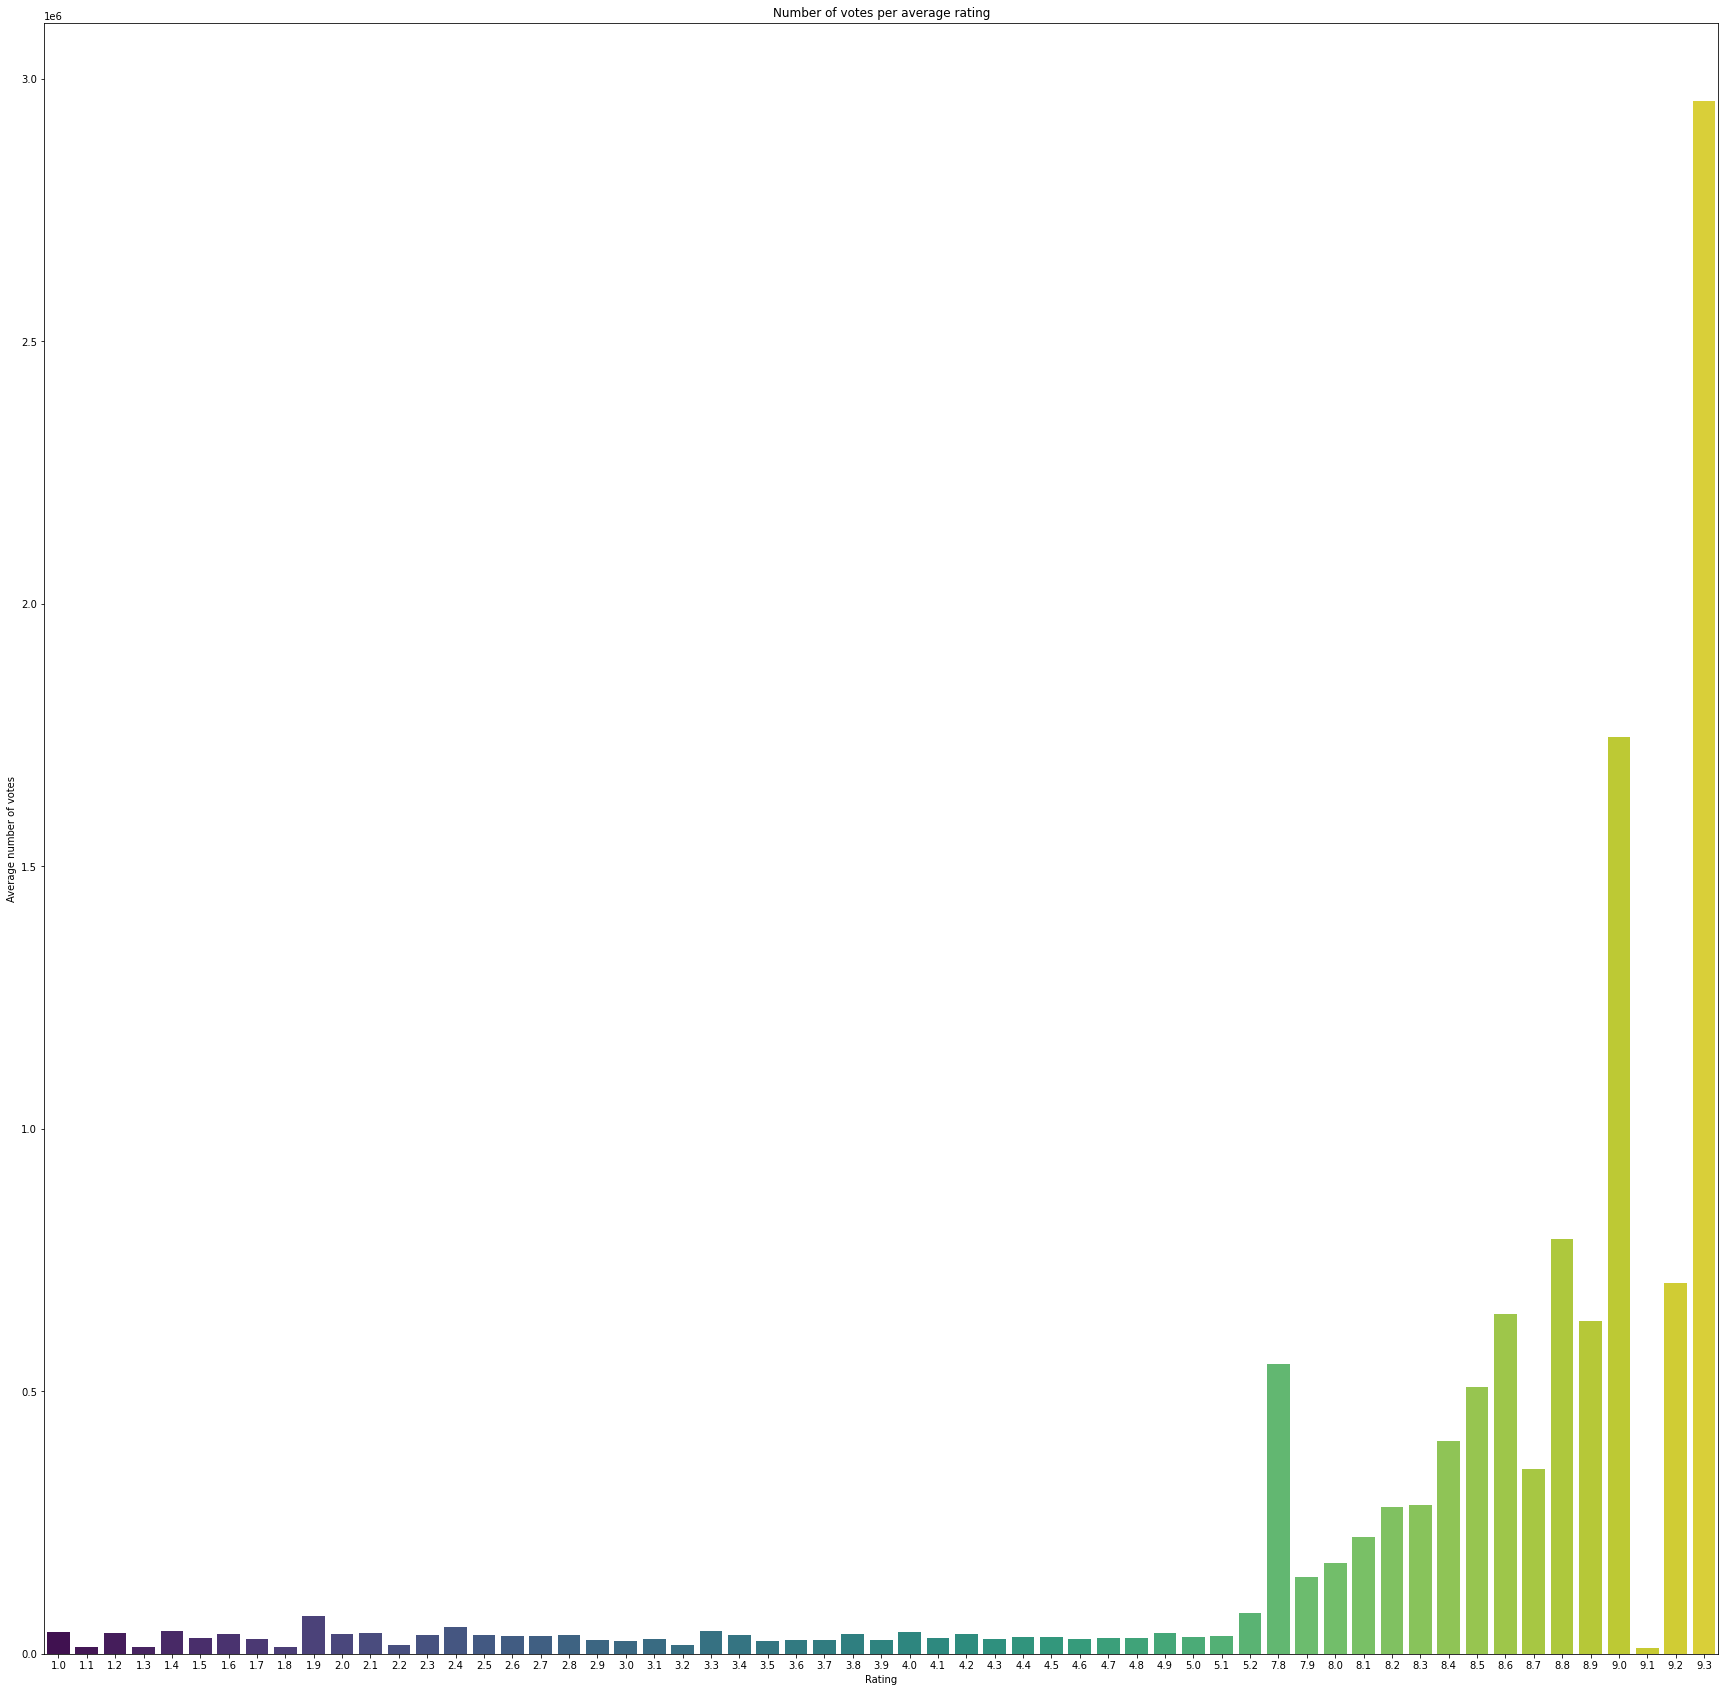

In [29]:
# Average number of votes per rating
avg_votes = df.groupby('averageRating')['numVotes'].mean()

plt.figure(figsize=(30,30))

sns.barplot(x=avg_votes.index, y=avg_votes.values, palette='viridis')

plt.title("Number of votes per average rating")
plt.xlabel("Rating")
plt.ylabel("Average number of votes")

plt.show()

In [30]:
# The average number of votes per rating is higher for higher ratings as compared to lower ones.

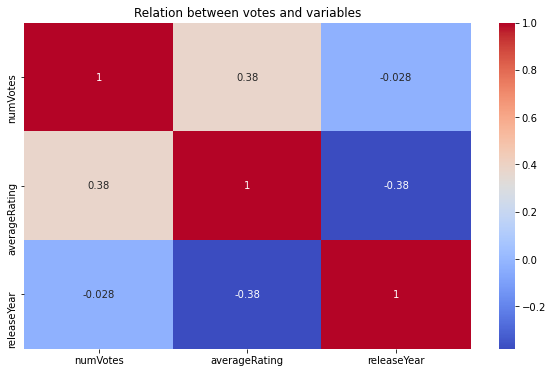

In [31]:
# Correlation check
correlation_matrix = df[['numVotes', 'averageRating', 'releaseYear']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Relation between votes and variables')
plt.show()

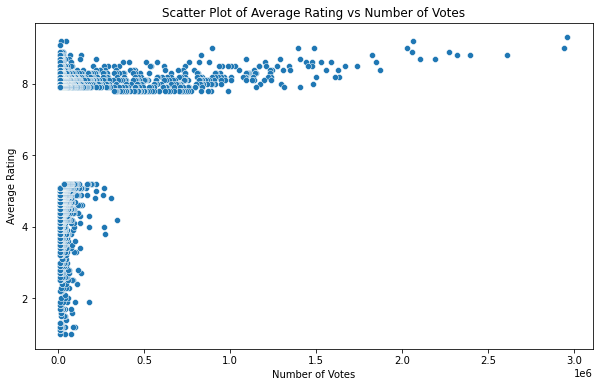

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='numVotes', y='averageRating', data=df)
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Rating vs Number of Votes')
plt.show()

In [33]:
# A minor positive correlation is seen for num votes and avg rating. As num votes increase, average rating also increases.

In [34]:
# The genre column has multiples genres given with commas. We need to correct this and make sure one column has one genre only.
# Split all the genres
# Step-1 Stripping the extra whitespace from the genre
df['genres'] = df['genres'].str.strip().str.title()
# Step-2 splling the genres
df['genres'] = df['genres'].apply(lambda x: x.split(',')) 
# Step-3 Removing any extra whitespace from each genre in the list. This was causing a problem as we had extra columns because og whitespace
df['genres'] = df['genres'].apply(lambda genres: [genre.strip() for genre in genres if genre])


# Using MultiLabelBinarizer for encoding 
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres'])
genres_data = pd.DataFrame(genres_encoded, columns=mlb.classes_)
df = pd.concat([df.drop(columns=['genres']), genres_data], axis=1)

In [35]:
df

,title,averageRating,numVotes,releaseYear,Action,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-Tv,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,The Shawshank Redemption,9.3,2958776,1994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,9.2,2062792,1972,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,The Chaos Class,9.2,43660,1975,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Ramayana: The Legend of Prince Rama,9.2,15522,1993,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Silence of Swastika,9.1,10572,2021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,The Bad Batch,5.2,36189,2016,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,Alex Cross,5.2,35725,2012,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1997,Asterix at the Olympic Games,5.2,33127,2008,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1998,The Lords of Salem,5.2,32998,2012,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
# Now for each genre, 1 means it is present for that movie and 0 means it is not

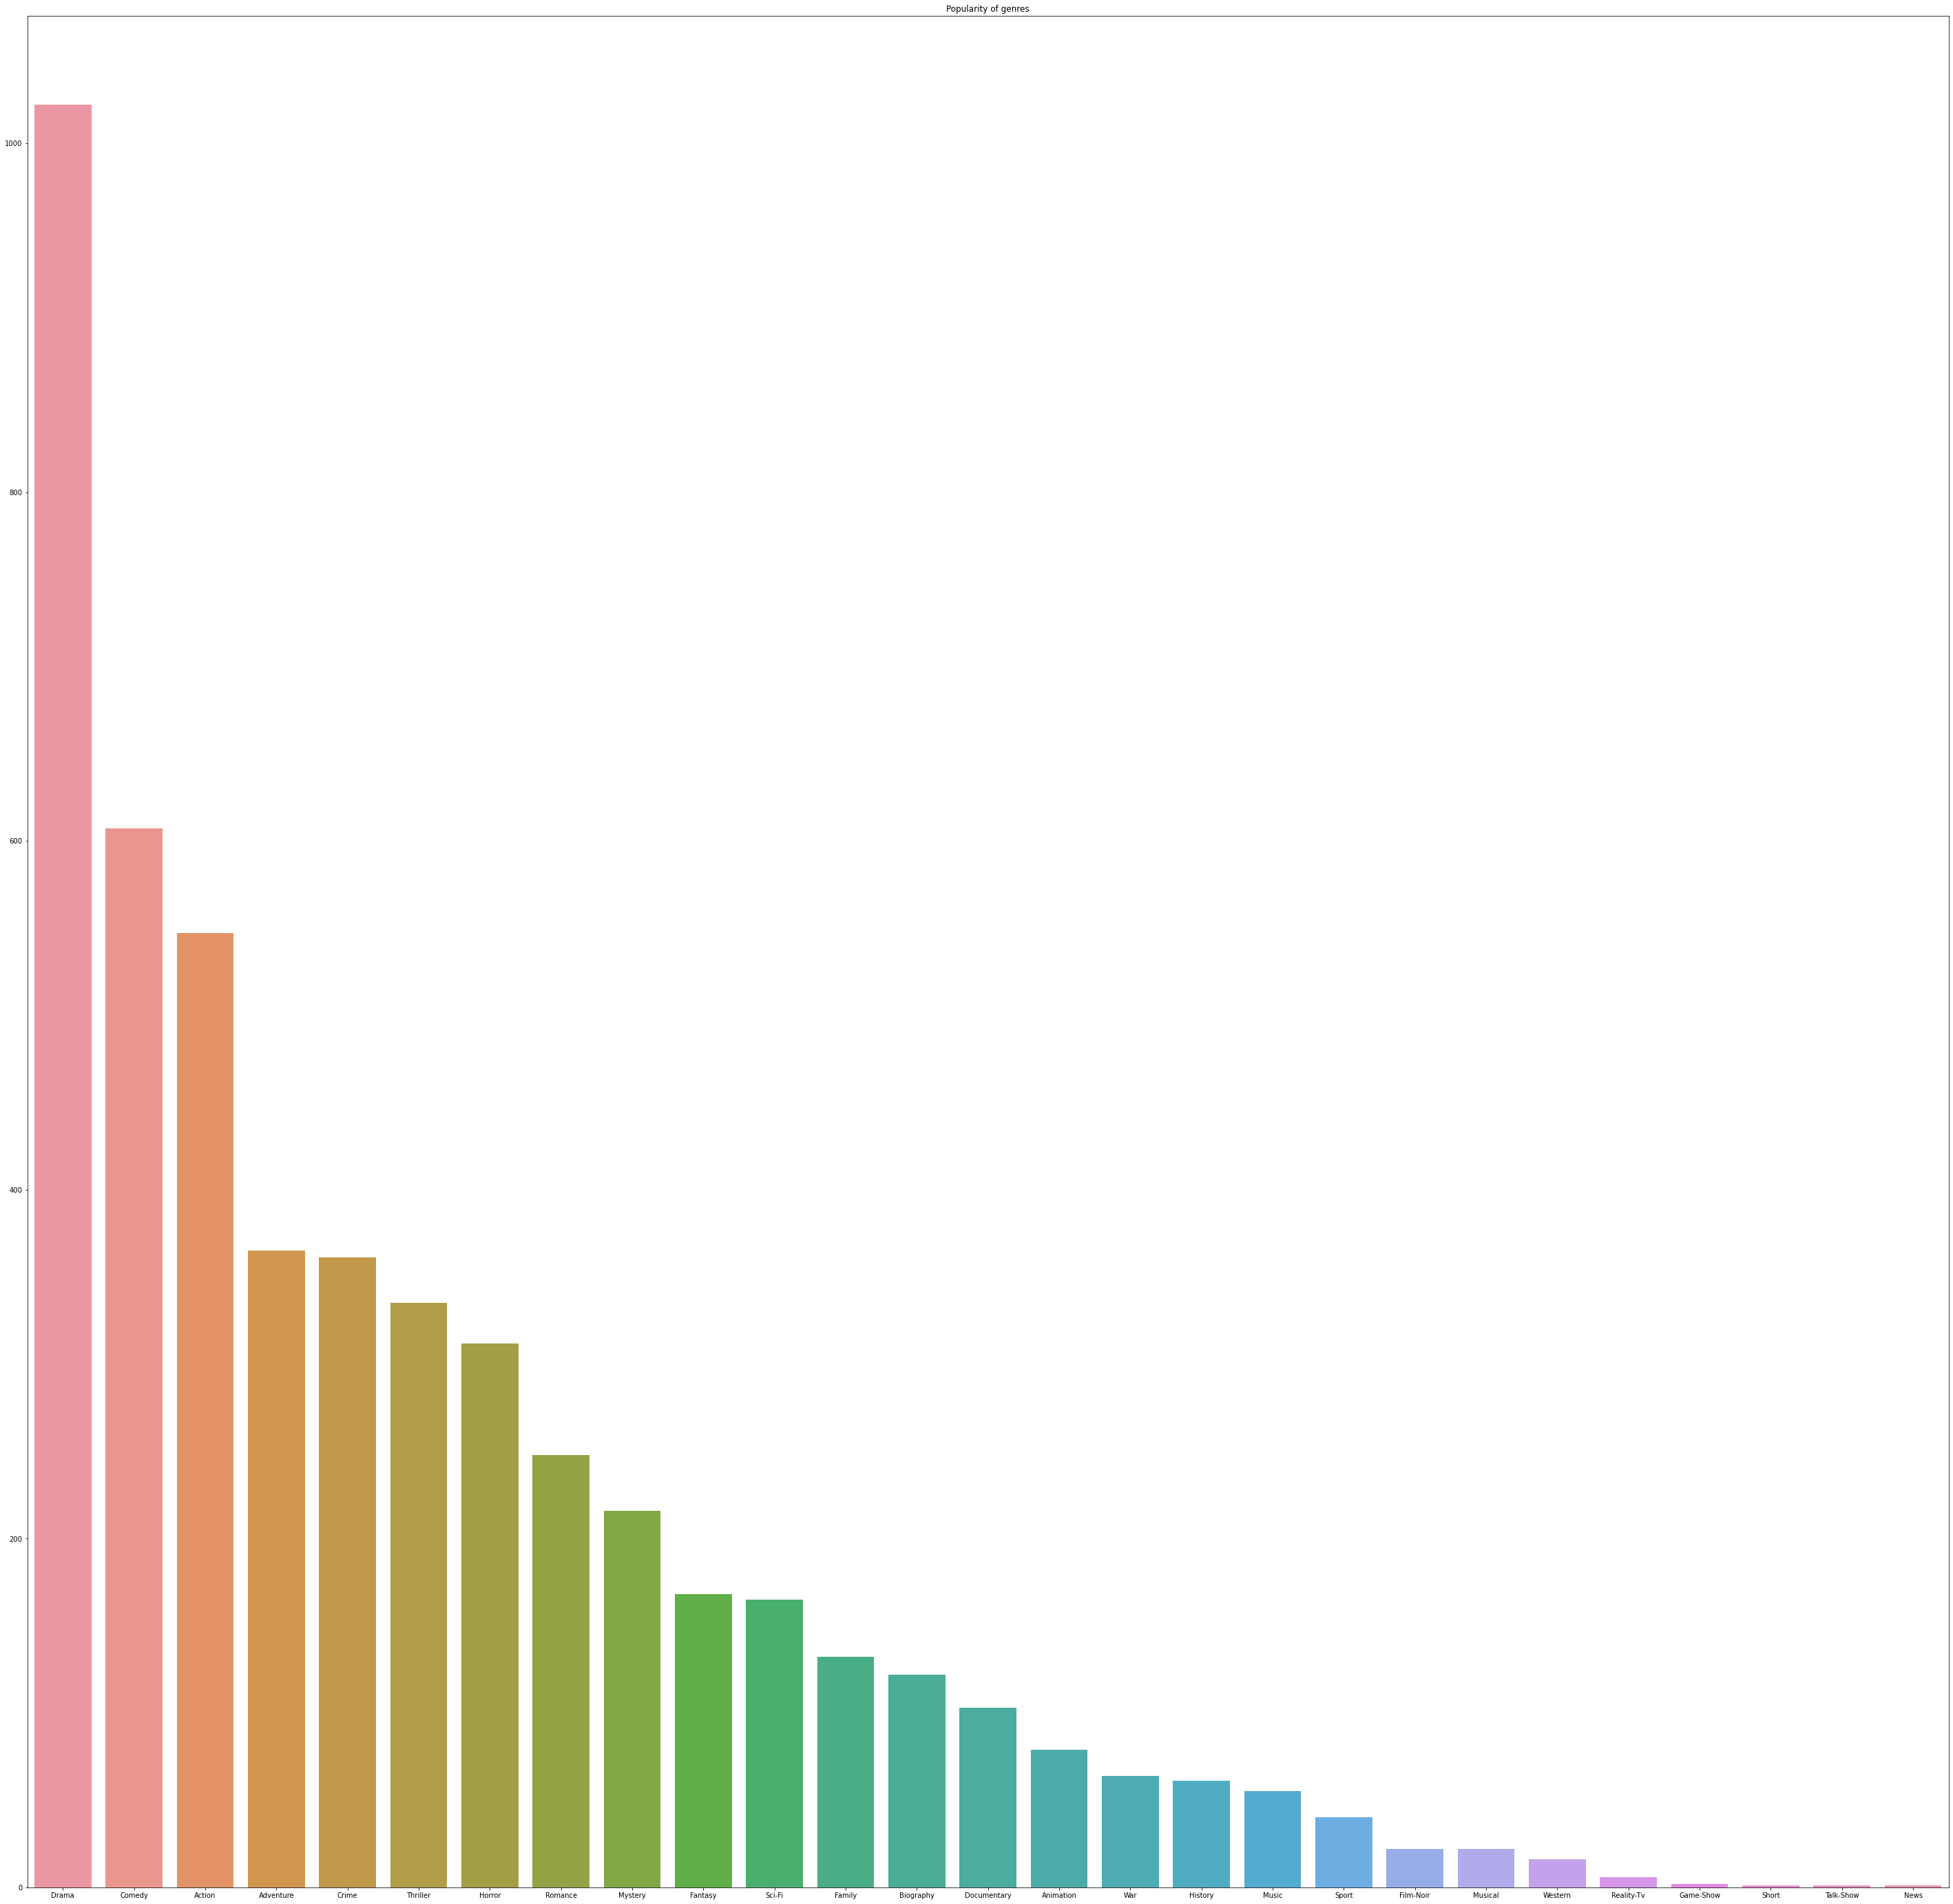

In [37]:
# Analyzing the most popular genres
genre_popularity = genres_data.sum().sort_values(ascending=False)
plt.figure(figsize=(50, 50))
sns.barplot(x=genre_popularity.index, y=genre_popularity.values)
plt.title('Popularity of genres')
plt.show()

In [38]:
genre_popularity

Drama          1022
Comedy          607
Action          547
Adventure       365
Crime           361
Thriller        335
Horror          312
Romance         248
Mystery         216
Fantasy         168
Sci-Fi          165
Family          132
Biography       122
Documentary     103
Animation        79
War              64
History          61
Music            55
Sport            40
Film-Noir        22
Musical          22
Western          16
Reality-Tv        6
Game-Show         2
Short             1
Talk-Show         1
News              1
dtype: int64

In [39]:
# In the dataset there are 27 genres and the most popular genre happens to be drama, the least popular one being news.

In [40]:
# We will aim to find the most popular genre based on the count each year-
pd.set_option('display.max_rows', None)

genre_counts_every_year = []
# We will loop through each genre and find the sum for each year
for genre in genres_data.columns:
    genre_df = df[df[genre] == 1]
    genre_count = genre_df.groupby('releaseYear').size().reset_index(name='count')
    genre_count['genre'] = genre
    genre_counts_every_year.append(genre_count)

genre_counts_every_year = pd.concat(genre_counts_every_year)
most_popular_genre_every_year = genre_counts_every_year.loc[genre_counts_every_year.groupby('releaseYear')['count'].idxmax()]
print(most_popular_genre_every_year[['releaseYear', 'genre', 'count']])

    releaseYear        genre  count
0          1923       Action      1
0          1925    Adventure      1
0          1975    Animation      1
0          1928    Biography      1
0          1921       Comedy      1
0          1931        Crime      1
0          1929  Documentary      1
0          1921        Drama      2
0          1921       Family      1
0          1921      Fantasy      1
0          1932    Film-Noir      1
0          2002    Game-Show      1
0          1925      History      1
0          1920       Horror      1
0          1948        Music      1
0          1952      Musical      1
0          1920      Mystery      1
0          2016         News      1
0          2005   Reality-Tv      1
0          1924      Romance      1
0          1927       Sci-Fi      1
0          2022        Short      1
0          1950        Sport      1
0          1997    Talk-Show      1
0          1920     Thriller      1
0          1930          War      1
0          1924      Western

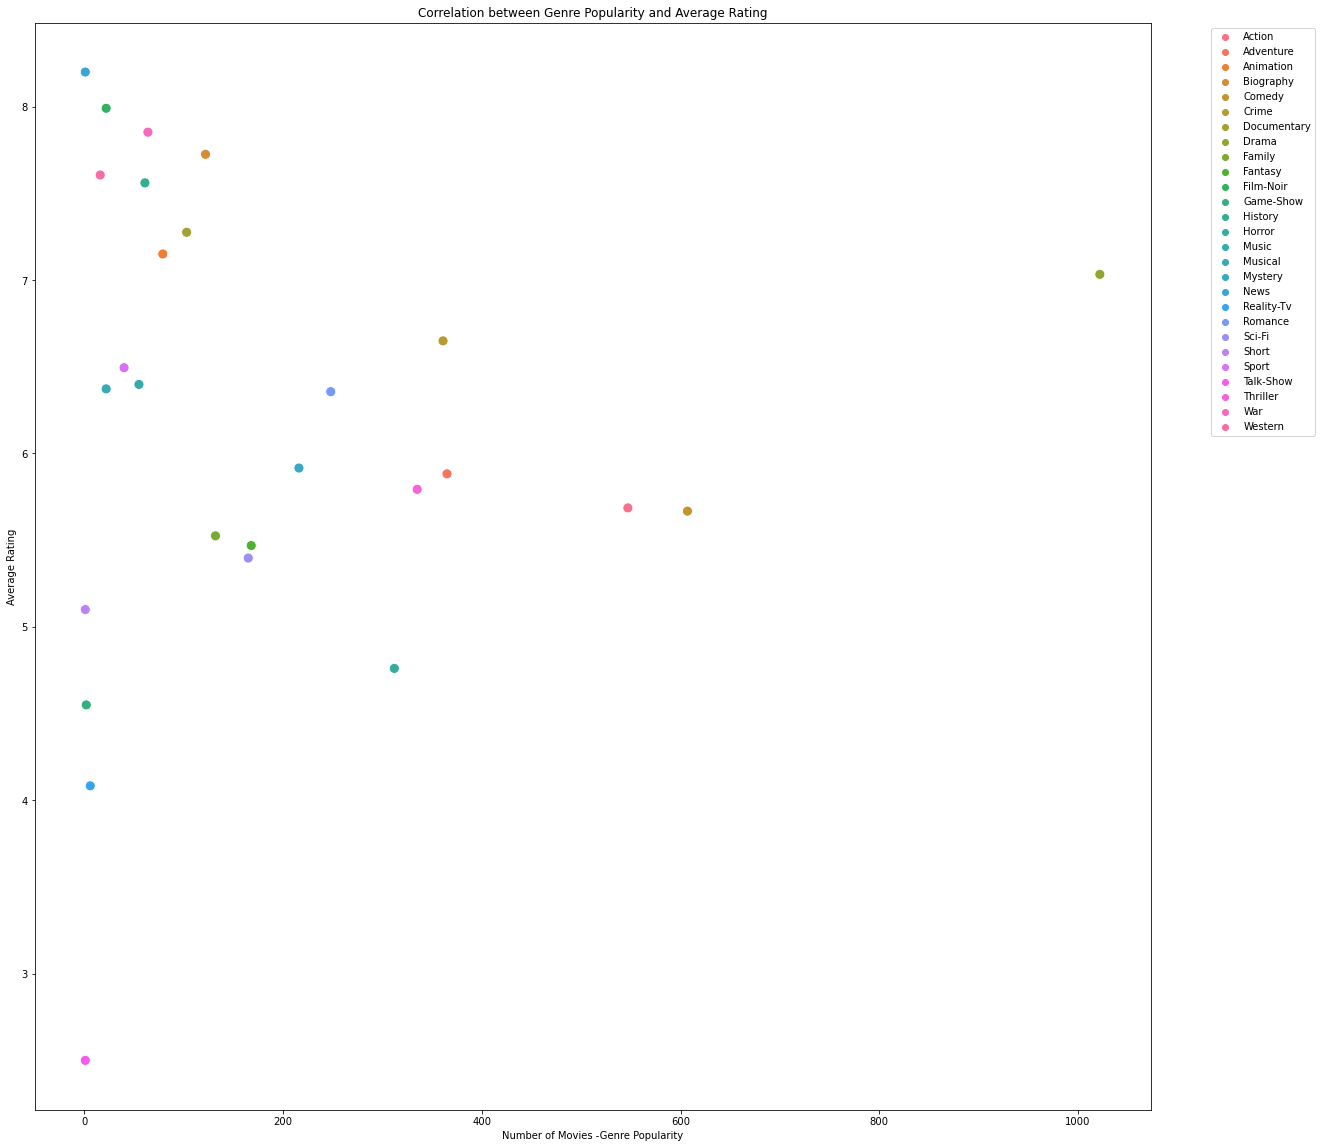

In [41]:
# Examining popular genres and their typical ratings to identify correlations

genres = []
counts = []
average_ratings = []
average_num_votes=[]

#For each genre calculating the count and the average rating
for genre in genres_data.columns:
    genre_movies = df[df[genre] == 1]  # Filtering only where the genre is present
    genres.append(genre) # Adding genre name to genre list
    counts.append(len(genre_movies))  # Count of movies in the particular genre
    average_ratings.append(genre_movies['averageRating'].mean())  # Average rating of the genre
    average_num_votes.append(genre_movies['numVotes'].mean())

# Creating a DataFrame 
new_df = pd.DataFrame({
    'genre': genres,
    'Count_of_movies': counts,
    'average_rating': average_ratings,
    'average_num_votes': average_num_votes
})

# Plotting the correlation
plt.figure(figsize=(20, 20))
sns.scatterplot(data=new_df, x='Count_of_movies', y='average_rating', hue='genre', s=100)
plt.title('Correlation between Genre Popularity and Average Rating')
plt.xlabel('Number of Movies -Genre Popularity')
plt.ylabel('Average Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [42]:
# No correlation is visible.

In [43]:
new_df.sort_values(by='average_rating',ascending=False)

,genre,Count_of_movies,average_rating,average_num_votes
17,News,1,8.200000,29107.000000
10,Film-Noir,22,7.990909,81843.409091
25,War,64,7.853125,200558.953125
3,Biography,122,7.725410,228008.573770
26,Western,16,7.606250,291542.062500
12,History,61,7.560656,141863.459016
6,Documentary,103,7.275728,29094.077670
2,Animation,79,7.150633,295589.974684
7,Drama,1022,7.033072,188793.090020
5,Crime,361,6.649584,185891.224377


In [44]:
# Findings-
# Drama has the most movies (1,022), followed by Comedy (607) and Action (547)
# News has the highest average rating of 8.2, though it only has 1 movie in this dataset
# Film-Noir, War, and Biography also have high average ratings (around 7.7–8), suggesting these genres tend to be critically acclaimed
# Talk-Show has the lowest average rating at 2.5, although this is based on only one movie.
# Other genres with lower average ratings include Reality-TV, Game-Show, and Horror
# Sci-Fi and Animation have high average vote counts (above 260,000), indicating a large, engaged fan base
# Adventure and Western also received high numbers of votes on average, suggesting they attract more audience interaction

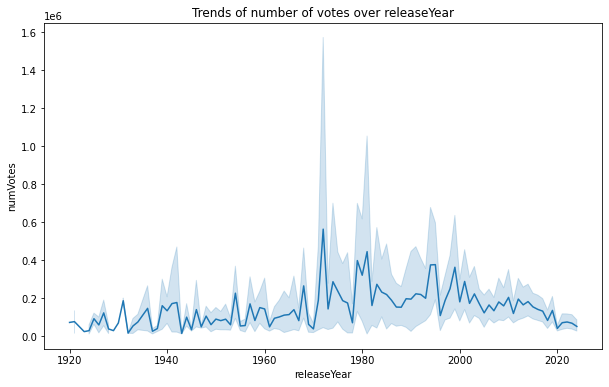

In [45]:
# analyzing the relationship between release year and num votes
plt.figure(figsize=(10, 6))
sns.lineplot(x='releaseYear', y='numVotes', data=df)
plt.title('Trends of number of votes over releaseYear')
plt.show()


In [46]:
#Before 1940, the number of votes is generally low, which could be due to fewer movies
#The number of votes slowly increases until the 1980s, with some fluctuations.
# In the late 1970s A notable spike occurs, suggesting that some movies from this period garnered exceptionally high vote counts
# From around 1980 to 2000, there are several high and low points, indicating fluctuations 
# After 2000, there’s a gradual decrease in votes, although the volume is still higher than the pre-1980 era

# Feature Engineering

In [47]:
# Removing outliers-
Q1 = df['averageRating'].quantile(0.25)
Q3 = df['averageRating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['averageRating'] >= lower_bound) & (df['averageRating'] <= upper_bound)]
df.head(5)

,title,averageRating,numVotes,releaseYear,Action,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-Tv,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,The Shawshank Redemption,9.3,2958776,1994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,9.2,2062792,1972,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,The Chaos Class,9.2,43660,1975,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Ramayana: The Legend of Prince Rama,9.2,15522,1993,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Silence of Swastika,9.1,10572,2021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
Q1 = df['releaseYear'].quantile(0.25)
Q3 = df['releaseYear'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['releaseYear'] >= lower_bound) & (df['releaseYear'] <= upper_bound)]
df.head(5)

,title,averageRating,numVotes,releaseYear,Action,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-Tv,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,The Shawshank Redemption,9.3,2958776,1994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,9.2,2062792,1972,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,The Chaos Class,9.2,43660,1975,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Ramayana: The Legend of Prince Rama,9.2,15522,1993,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Silence of Swastika,9.1,10572,2021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df.isnull().sum()

title            0
averageRating    0
numVotes         0
releaseYear      0
Action           0
Adventure        0
Animation        0
Biography        0
Comedy           0
Crime            0
Documentary      0
Drama            0
Family           0
Fantasy          0
Film-Noir        0
Game-Show        0
History          0
Horror           0
Music            0
Musical          0
Mystery          0
News             0
Reality-Tv       0
Romance          0
Sci-Fi           0
Short            0
Sport            0
Talk-Show        0
Thriller         0
War              0
Western          0
dtype: int64

In [50]:
df.shape

(1844, 31)

In [51]:
# Additional feature-
# Number of genres per movie
df['Num_Genres'] = genres_data.sum(axis=1)

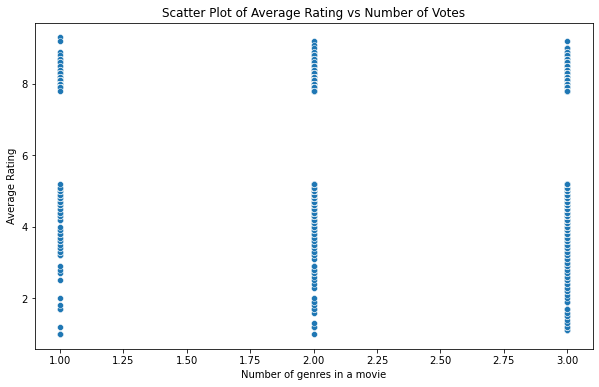

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Num_Genres', y='averageRating', data=df)
plt.xlabel('Number of genres in a movie')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Rating vs Number of Votes')
plt.show()

In [53]:
# No correlation can be seen between number of genres and average rating.

In [54]:
numerical_features = ['releaseYear','numVotes','Num_Genres']

In [55]:
scaler=StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [56]:
scaler.fit(df[numerical_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [57]:
df.head(5)

,title,averageRating,numVotes,releaseYear,Action,Adventure,Animation,Biography,Comedy,Crime,...,Reality-Tv,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Num_Genres
0,The Shawshank Redemption,9.3,8.278312,-0.768869,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.275582
1,The Godfather,9.2,5.627841,-2.256018,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-0.799096
2,The Chaos Class,9.2,-0.345091,-2.053225,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-2.275582
3,Ramayana: The Legend of Prince Rama,9.2,-0.428328,-0.836466,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.677390
4,The Silence of Swastika,9.1,-0.442971,1.056269,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.799096


In [57]:
# Removing the title column as it is of no use to our prediction
df.drop('title',axis=1,inplace=True)

# Model selection and training-

In [58]:
# Features and target
Features = df.drop(columns=['averageRating'])  
Target = df['averageRating'] 

In [59]:
# Train test split-
X_train, X_test, y_train, y_test = train_test_split(Features,Target, test_size=0.2, random_state=42)

In [60]:
# Fitting model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Prediction-
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

In [62]:
# Model evaluation
from sklearn.metrics import mean_squared_error, r2_score  , mean_absolute_error
# r squared
r2 = r2_score(y_test, y_pred) 
r2_train=r2_score(y_train, y_pred_train) 
print(f"R² Score for test is: {r2}")
print(f"R² Score for train is: {r2_train}")

R² Score for test is: 0.43368436051854853
R² Score for train is: 0.47294393984589334


In [63]:
mse = mean_squared_error(y_test, y_pred) 
mse_train = mean_squared_error(y_train, y_pred_train) 
print(f"Mean Squared Error test is: {mse}")
print(f"Mean Squared Error train is: {mse_train}")

Mean Squared Error test is: 2.202194690982695
Mean Squared Error train is: 2.16459469014129


In [64]:
mae = mean_absolute_error(y_test, y_pred)
mae_train=mean_absolute_error(y_train, y_pred_train)
print(f"Mean Absolute Error (MAE) test is: {mae}")
print(f"Mean Absolute Error train is: {mae_train}")

Mean Absolute Error (MAE) test is: 1.188454989579016
Mean Absolute Error train is: 1.1326996429466254


In [65]:
# Root mean squared error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) for test: {rmse}")
rmse_train=np.sqrt(mse_train)
print(f"Root Mean Squared Error (RMSE) for train: {rmse_train}")

Root Mean Squared Error (RMSE) for test: 1.4839793431792423
Root Mean Squared Error (RMSE) for train: 1.4712561606128587


In [66]:
# The model does not overfit. However,
# Here, an R² score of 0.434 indicates that the model explains approximately 43.4% of the variance in the test data. 
# A test MAE of 1.188 indicates that, on average, the model’s predictions are off by about 1.19 units from the actual values
# An RMSE of 1.484 means that, on average, the model's predictions for the test set are off by about 1.484 units from the actual values. This is substatial.

In [67]:
# Features with their coefficients:
df5 = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})

print(df5)

        Feature   Coefficient
0      numVotes  6.409581e-01
1   releaseYear -5.131905e-01
2        Action -9.989920e-02
3     Adventure -9.058343e-02
4     Animation  1.442725e+00
5     Biography  7.478011e-01
6        Comedy -1.165209e-01
7         Crime  2.920502e-01
8   Documentary  1.694911e+00
9         Drama  1.238062e+00
10       Family -3.039005e-01
11      Fantasy -1.966572e-01
12    Film-Noir -6.661338e-16
13    Game-Show -1.350276e+00
14      History  2.890712e-01
15       Horror -7.252672e-01
16        Music -3.301619e-01
17      Musical  4.888530e-01
18      Mystery  1.545980e-01
19         News  1.627431e+00
20   Reality-Tv -1.045804e+00
21      Romance  3.286493e-02
22       Sci-Fi -3.453302e-01
23        Short -5.448549e-01
24        Sport -1.724505e-01
25    Talk-Show -3.139096e+00
26     Thriller  1.633340e-01
27          War  5.870560e-01
28      Western -3.614247e-01
29   Num_Genres -9.371035e-02


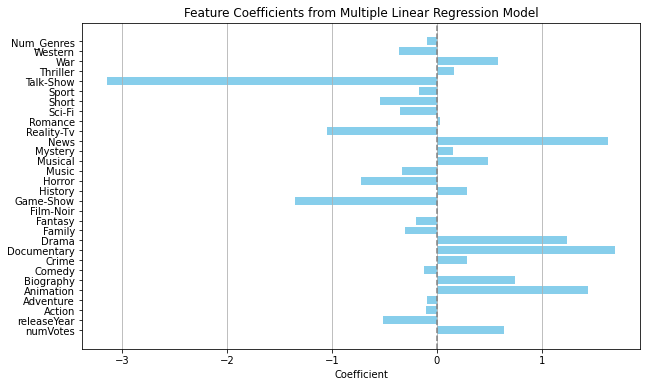

In [68]:
# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(df5['Feature'], df5['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Feature Coefficients from Multiple Linear Regression Model')
plt.axvline(0, color='grey', linestyle='--')  
plt.grid(axis='x')
plt.show()

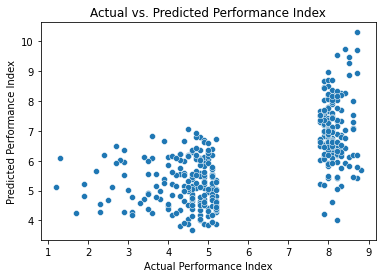

In [69]:
# Plot of actual vs predicted values
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')
plt.title('Actual vs. Predicted Performance Index')
plt.show()

In [70]:
#Creating a list for model comparison
column_names=['Model_Name','R2','MSE','RMSE']
model_comp = pd.DataFrame(columns=column_names)

In [71]:
model_comp.loc[0]= ['Multiple Linear Regression',0.4336,2.2021,1.4839]

In [72]:
# Before model comparison , we will create a function to automatically generate evaluation metrics
def evaluation_generator(true_val, predicted_val):  
    mae =mean_absolute_error(true_val, predicted_val)
    mse = mean_squared_error(true_val, predicted_val)
    rmse = np.sqrt(mean_squared_error(true_val, predicted_val))
    r2_square = r2_score(true_val, predicted_val)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

### Decision tree regressor

In [73]:
from sklearn.tree import DecisionTreeRegressor
# Initializing the model
model = DecisionTreeRegressor(random_state=42)

# Training the model
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [74]:
# Prediction
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [75]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0658536585365852
MSE: 3.0162330623306235
RMSE: 1.7367305669938051
R2 Square 0.224346529163308
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.3849561798713818e-17
MSE: 1.2300881911920862e-32
RMSE: 1.1090934095882484e-16
R2 Square 1.0
__________________________________


In [76]:
# The model overfits, we need hyperparametric tuning.

In [77]:
#Feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

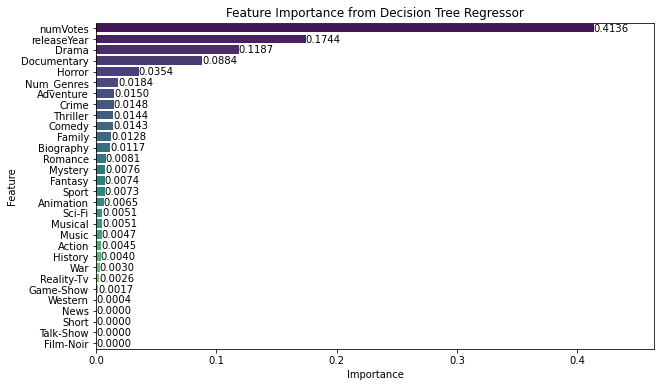

In [78]:
# Plotting the feature importance
plt.figure(figsize=(10, 6))

bar_plot = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


for index, value in enumerate(feature_importance_df['Importance']):
    bar_plot.text(value, index, f'{value:.4f}', color='black', ha="left", va="center")

plt.title('Feature Importance from Decision Tree Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xlim(0, feature_importance_df['Importance'].max() + 0.05)  
plt.show()

In [79]:
# Num votes and release year are the 2 most important features.

In [80]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False) 
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [3.68345763 3.26891525 3.18288136 4.01159322 3.50383051]
Mean MSE: 3.5301355932203387
Cross-Validation R² Scores: [0.11249777 0.13806224 0.30203917 0.01545951 0.1033128 ]
Mean R²: 0.1342743003829996


In [81]:
# Hyper parametric tuning-
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)


In [82]:
# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Estimator: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')


In [83]:

# Fit the best estimator to the training data
best_estimator.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator.predict(X_test)
y_pred_train=best_estimator.predict(X_train)

In [84]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0459600189274307
MSE: 2.2998768739497413
RMSE: 1.516534494810369
R2 Square 0.4085644434923923
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.819723899049551
MSE: 1.528759859020234
RMSE: 1.2364302887830896
R2 Square 0.6277630394795255
__________________________________


In [85]:
# The errors reduce and the the r squared increases post hyper parametric tuning. The model overfit also reduces.

In [86]:
# Randomized search cv
# Parameter distribution
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)


In [87]:
# Fit random search
random_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10}
Best Estimator: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')


In [88]:
# Fit the best estimator to the training data
best_estimator.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator.predict(X_test)
y_pred_train = best_estimator.predict(X_train)

In [89]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.007596043669621
MSE: 2.1925470629782655
RMSE: 1.4807251814493685
R2 Square 0.4361653412625215
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8540310092110793
MSE: 1.5993151674645887
RMSE: 1.2646403312660042
R2 Square 0.6105835633119978
__________________________________


In [90]:
# The errors reduce and the the r squared increases post hyper parametric tuning. The model overfit also reduces.

In [91]:
model_comp.loc[1]=['Decision Tree Regressor',0.4361,2.1926,1.4807]

In [92]:
# The best RMSE comes from the randomized search cv tuning.
# The decision tree still overfits.
# model explains approximately 43.6% of the variance in the test data
# An MAE of approximately 1.008 means that, on average, the model's predictions are off by about 1.008 units from the actual values
# An RMSE of 1.481 suggests that the typical prediction error is about 1.481 units

### Random forest regressor

In [93]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [94]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [95]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9808346883468836
MSE: 2.029195669376694
RMSE: 1.4244983921987044
R2 Square 0.4781727302124875
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.34369152542372844
MSE: 0.2694068508474576
RMSE: 0.5190441704204543
R2 Square 0.9344022629118998
__________________________________


In [96]:
#Feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

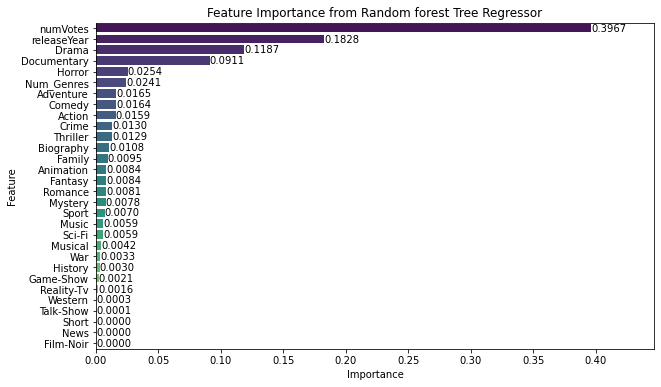

In [97]:
# Plotting the feature importance
plt.figure(figsize=(10, 6))

bar_plot = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


for index, value in enumerate(feature_importance_df['Importance']):
    bar_plot.text(value, index, f'{value:.4f}', color='black', ha="left", va="center")

plt.title('Feature Importance from Random forest Tree Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xlim(0, feature_importance_df['Importance'].max() + 0.05)  
plt.show()

In [98]:
# The most important features are num votes and release year.

In [99]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Set `greater_is_better=False` since we want to minimize MSE
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [2.14769056 1.75169515 1.88475033 2.34612713 1.69112847]
Mean MSE: 1.9642783267796609
Cross-Validation R² Scores: [0.48252964 0.53811829 0.58670093 0.42420455 0.56721273]
Mean R²: 0.5197532249048331


In [100]:
# Hyper parametric tuning-
# Define parameter grid (smaller grid for faster execution)
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)


In [101]:

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [102]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [103]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9899205698266124
MSE: 1.920859393140907
RMSE: 1.3859507181501465
R2 Square 0.5060324502484719
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5688135368084564
MSE: 0.6843241824933445
RMSE: 0.8272388908249808
R2 Square 0.8333742528632095
__________________________________


In [104]:
# Randomized search cv
# Define parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [105]:
# Best parameters and model
best_params_random = random_search.best_params_
best_estimator_random = random_search.best_estimator_

print("Best Parameters (RandomizedSearchCV):", best_params_random)

Best Parameters (RandomizedSearchCV): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [106]:
# Fit the best estimator to the training data
best_estimator_random.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_random.predict(X_test)
y_pred_train = best_estimator_random.predict(X_train)

In [107]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0153214206519847
MSE: 1.9623489488476074
RMSE: 1.4008386591066109
R2 Square 0.4953630101812285
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.7100341473981089
MSE: 1.0179429880866773
RMSE: 1.0089316072393992
R2 Square 0.7521415795732905
__________________________________


In [205]:
# The best fit comes from grid search cv tuning. There is some overfitting even after tuning.
# A MAE of 0.989 means that, on average, the model's predictions deviate from the actual values by about 0.989 units.
# An RMSE of 1.385 indicates that, on average, the model's predictions deviate from actual values by approximately 1.385 units
# An R² of 0.506 suggests that the model explains around 50.6% of the variance in the target variable

In [206]:
model_comp.loc[2]=['Random forest regressor', 0.5060,1.9208,1.3859]

### Suport vector regressor

In [110]:
# Support vector regressor
from sklearn.svm import SVR
# Train the model
model=SVR()
model.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [111]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [112]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9266620382332796
MSE: 2.009686918358675
RMSE: 1.41763426819426
R2 Square 0.48318959400454564
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8099123008631979
MSE: 1.7208828979833009
RMSE: 1.3118242633765016
R2 Square 0.58098309843934
__________________________________


In [113]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Setting greater_is_better=False since we want to minimize MSE
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [1.89111605 1.71525565 2.2126895  2.42710828 1.69581092]
Mean MSE: 1.9883960797790015
Cross-Validation R² Scores: [0.54434939 0.54772654 0.51478851 0.40432984 0.56601441]
Mean R²: 0.5154417401455665


In [114]:
# Hyper parametric tuning-
# Define parameter grid
svr = SVR()
param_grid = {
    'C': [1, 10],
    'epsilon': [0.1, 0.2],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10], 'epsilon': [0.1, 0.2],
                         'gamma': ['scale'], 'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [115]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}


In [116]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [117]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9326100723445166
MSE: 1.9929681662329088
RMSE: 1.411725244597159
R2 Square 0.4874889826281783
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8203277222640483
MSE: 1.7033622454547848
RMSE: 1.305129206421642
R2 Square 0.585249193212217
__________________________________


In [118]:
# The mae value indicates:  On average, the model's predictions are off by about 0.93 units from the actual values.
# The average of the squared differences between predicted and actual values is about 1.99.
#An RMSE of 1.4117 indicates that, on average, the model's predictions deviate from actual values by approximately 1.4117 units
# The model explains about 49% of the variance in the target variable


In [207]:
model_comp.loc[3]=['Support vector regressor',0.4874,1.9929,1.4117]

### Polynomial regression

In [120]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

In [121]:
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 7339108789588.205
MSE: 4.469871894737832e+27
RMSE: 66857100555870.89
R2 Square -1.1494707397278501e+27
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.9400540254237287
MSE: 1.598477550648835
RMSE: 1.2643091198946699
R2 Square 0.6107875142044401
__________________________________


In [122]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(lin_reg , X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(lin_reg , X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [7.09599330e+21 8.66388967e+20 2.52264691e+00 2.45865967e+00
 2.03053363e+00]
Mean MSE: 1.5924764542387185e+21
Cross-Validation R² Scores: [-1.70972779e+21 -2.28446840e+20  4.46819239e-01  3.96586381e-01
  4.80353427e-01]
Mean R²: -3.876349255193371e+20


In [123]:
# As indicated by the metrics, the model is a terrible fit for the data. 

In [208]:
model_comp.loc[4]=['Polynomial Regression',-1.1494,4.4698,66857100555870.89]

### Stochastic Gradient descent

In [125]:
# Stochastic Gradient descent
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

In [126]:
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.3393336472653732
MSE: 2.8190306033979637
RMSE: 1.6789969039274504
R2 Square 0.27505904658742764
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.2866263557260003
MSE: 2.668851368948562
RMSE: 1.6336619506337784
R2 Square 0.350162737596336
__________________________________


In [127]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(sgd_reg , X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(sgd_reg , X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [2.67923875 2.59533672 2.83947362 2.72169997 2.88249544]
Mean MSE: 2.7436488994584267
Cross-Validation R² Scores: [0.35441632 0.31567431 0.37730232 0.33205609 0.26220046]
Mean R²: 0.328329899590048


In [210]:
# MAE value indicates: On average, the model's predictions are off by about 1.34 units from the actual values.
#  The RMSE is about 1.68 units, meaning the typical prediction error is around this value.
# he model explains about 28% of the variance in the target variable.

In [211]:
model_comp.loc[5]=['Stochastic Gradient descent',0.2750,2.8190,1.6789]

### XGB regressor

In [130]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [131]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [132]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0497273004475
MSE: 2.223293395497616
RMSE: 1.4910712241531643
R2 Square 0.4282586248247321
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.235328841581183
MSE: 0.11663450677680577
RMSE: 0.341517945028963
R2 Square 0.9716007232671405
__________________________________


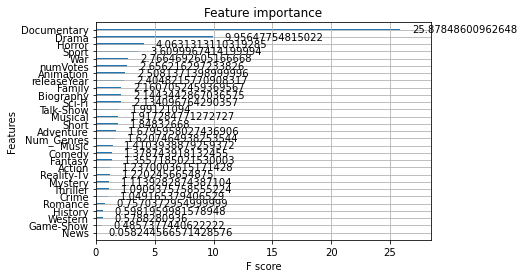

In [133]:
from xgboost import plot_importance

plot_importance(model, importance_type='gain')  # You can use 'weight' or 'coverage' as well
plt.show()

In [134]:
# Hyper parametric tuning:
# Define parameter grid (smaller grid for demonstration)
xgb = XGBRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={

In [135]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


In [136]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [137]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0147134225219892
MSE: 1.9517474932744252
RMSE: 1.3970495672217307
R2 Square 0.49808927689912785
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.7346822572966754
MSE: 1.0787700275009144
RMSE: 1.0386385451642521
R2 Square 0.7373308346839488
__________________________________


In [138]:
# Randomized search cv
# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=20, n_jobs=-1,
    

In [139]:
# Best parameters and model
best_params_random = random_search.best_params_
best_estimator_random = random_search.best_estimator_

print("Best Parameters (RandomizedSearchCV):", best_params_random)

Best Parameters (RandomizedSearchCV): {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [140]:
# Fit the best estimator to the training data
best_estimator_random.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_random.predict(X_test)
y_pred_train = best_estimator_random.predict(X_train)

In [141]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0157808421426995
MSE: 1.9376965536437367
RMSE: 1.3920116930700464
R2 Square 0.501702611766772
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.7809677339004258
MSE: 1.1944259508938337
RMSE: 1.092897959964165
R2 Square 0.7091698327215081
__________________________________


In [142]:
# The best fit comes from random search cv.  
# The MAE of 1.015 suggests that, on average, the model’s predictions are off by about 1.015 units from the actual values.
# The MSE of 1.937 is the average of the squared differences between predicted and actual values. 
# An RMSE of 1.392 means the model’s predictions typically deviate from the actual values by around 1.392 units.
#  An R² value above 0.5 shows that the model has captured a moderate level of the variance of the target variable.
# The model overfits but it is far lesser as compared to other models.

In [212]:
model_comp.loc[6]=['XGB Regressor',0.5017,1.9376,1.3920]

### Adaboost regressor

In [144]:
from sklearn.ensemble import AdaBoostRegressor
base_regressor = DecisionTreeRegressor()
model = AdaBoostRegressor(base_estimator=base_regressor)
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [145]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [146]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.889430894308943
MSE: 2.2861246612466126
RMSE: 1.5119936048960698
R2 Square 0.41210095784470957
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.04793220338983052
MSE: 0.013837288135593219
RMSE: 0.1176320030246583
R2 Square 0.9966307657497363
__________________________________


In [147]:
# Performing cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  
r2_scorer = make_scorer(r2_score)
mse_scores = cross_val_score(model , X_train, y_train, cv=5, scoring=mse_scorer)
r2_scores = cross_val_score(model , X_train, y_train, cv=5, scoring=r2_scorer)

# Printing results
print("Cross-Validation MSE Scores:", -mse_scores)  
print("Mean MSE:", -mse_scores.mean())
print("Cross-Validation R² Scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Cross-Validation MSE Scores: [2.56630508 2.05511864 2.01322034 2.87518644 2.28223729]
Mean MSE: 2.3584135593220337
Cross-Validation R² Scores: [0.41110337 0.40370565 0.49811788 0.34090812 0.40944937]
Mean R²: 0.4126568790673007


In [148]:
# Hyper parametric tuning
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                              criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              min

In [149]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'learning_rate': 1.0, 'n_estimators': 200}


In [150]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [151]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.8997289972899729
MSE: 2.3269918699186993
RMSE: 1.5254480882411894
R2 Square 0.4015915603297119
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.04983050847457627
MSE: 0.013172881355932196
RMSE: 0.11477317350292357
R2 Square 0.9967925418185878
__________________________________


In [152]:
# Randomized search cv
# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=12,  
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                     

In [153]:
# Best parameters and model
best_params_random = random_search.best_params_
best_estimator_random = random_search.best_estimator_

print("Best Parameters (RandomizedSearchCV):", best_params_random)

Best Parameters (RandomizedSearchCV): {'n_estimators': 50, 'learning_rate': 1.0}


In [154]:
# Fit the best estimator to the training data
best_estimator_random.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_random.predict(X_test)
y_pred_train = best_estimator_random.predict(X_train)

In [155]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9382113821138209
MSE: 2.46639566395664
RMSE: 1.57047625386589
R2 Square 0.36574252795759765
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.04657627118644069
MSE: 0.012806779661016945
RMSE: 0.11316704317519719
R2 Square 0.9968816837340774
__________________________________


In [156]:
# The best fit comes from grid search cv. The model overfits.
# MAE value means that, on average, the model’s predictions deviate from the actual values by about 0.899 units.
# An RMSE of 1.5254 suggests that, on average, predictions are about 1.5254 units off from actual values
# An R² score of 0.4015 means that the model explains approximately 40.2% of the variance

In [213]:
model_comp.loc[7]=['Adaboost Regressor',0.4015,2.3269,1.5254]

### Ridge regression

In [158]:
# Ridge regression
model = Ridge(alpha=1.0)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [159]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.1889298170803895
MSE: 2.202421316918061
RMSE: 1.4840556987249707
R2 Square 0.4336260814699088
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.1353284999210174
MSE: 2.1672605460994596
RMSE: 1.4721618613791962
R2 Square 0.4722948319345367
__________________________________


In [160]:
# Defining a parameter grid to search over
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initializing Ridge regression model
ridge_model = Ridge()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitting the GridSearchCV to find the best hyperparameter
grid_search.fit(X_train, y_train)





GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [161]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'alpha': 10}


In [162]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [163]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.1910980528293311
MSE: 2.210727914434142
RMSE: 1.4868516786936556
R2 Square 0.4314899596712791
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.1457918670895006
MSE: 2.182820830925941
RMSE: 1.4774372510959446
R2 Square 0.46850606609635315
__________________________________


In [164]:
# MAE value means that, on average, the model’s predictions are off by about 1.191 units from the actual values. This model does not overfit.
# Here, an RMSE of 1.487 suggests that, on average, predictions deviate from actual values by approximately 1.487 units.
# The model explains approximately 43.1% of the variance in the target variable.

In [214]:
model_comp.loc[8]=['Ridge Regressor',0.4314,2.2107,1.4868]

### Lasso regression

In [166]:
# lasso

lasso_model = Lasso(alpha=1.0)

# Fitting the model on the training data
lasso_model.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [167]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [168]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.1889298170803895
MSE: 2.202421316918061
RMSE: 1.4840556987249707
R2 Square 0.4336260814699088
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.1353284999210174
MSE: 2.1672605460994596
RMSE: 1.4721618613791962
R2 Square 0.4722948319345367
__________________________________


In [169]:
# Defining a parameter grid 
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  
}

# Initializing Lasso regression model
lasso_model = Lasso()

# Set up GridSearchCV with cross-validation (5-fold)
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV to find the best hyperparameter (alpha)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [170]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'alpha': 0.01}


In [171]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [172]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.1931319282046575
MSE: 2.226910382700949
RMSE: 1.492283613359387
R2 Square 0.427328481622844
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.1542385260982657
MSE: 2.2078451515272515
RMSE: 1.4858819440074138
R2 Square 0.4624129070009203
__________________________________


In [173]:
# The MAE of 1.193 indicates that, on average, the model’s predictions are about 1.193 units away from the actual values.The model does not overfit.
# An RMSE of 1.492 indicates that predictions are, on average, about 1.492 units away from the actual values
# The R² score of 0.427 means that the model explains approximately 42.7% of the variance in the target variable

In [215]:
model_comp.loc[9]=['Lasso Regressor',0.4273,2.2269,1.4922]

### Elastic net

In [175]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='random', tol=0.0001, warm_start=False)

In [176]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [177]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.3479641204819364
MSE: 2.686826698402013
RMSE: 1.639154263149754
R2 Square 0.3090565579365798
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.3259376117430577
MSE: 2.6272227050247428
RMSE: 1.6208709711216198
R2 Square 0.36029887980212494
__________________________________


In [178]:
# The MAE of 1.347 means that, on average, the model’s predictions are about 1.347 units away from the actual values. The model does not overfit.
#  An RMSE of 1.639 indicates that predictions typically deviate from actual values by around 1.639 units
# The R² score of 0.309 indicates that the model explains only about 30.9% of the variance in the target variable.

In [217]:
model_comp.loc[10]=['Elastic Regressor',0.3090,2.6868,1.6391]

### LGBM

In [180]:
# LGBM
from lightgbm import LGBMRegressor
model = LGBMRegressor(n_estimators=100, random_state=60)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=60, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [181]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [182]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9918535518203104
MSE: 2.064700494724854
RMSE: 1.4369065713277445
R2 Square 0.46904232137349955
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6149129281159311
MSE: 0.7709186390703744
RMSE: 0.8780197259004916
R2 Square 0.8122894126746307
__________________________________


In [183]:
# Tuning
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(objective='regression', metric='l2', boosting_type='gbdt')

# Defining the parameter grid to search over
param_grid = {
    'num_leaves': [31, 50, 100],           # Number of leaves in each tree
    'learning_rate': [0.01, 0.05, 0.1],    # Step size
    'n_estimators': [50, 100, 200],        # Number of boosting rounds
    'max_depth': [-1, 3, 5],                # Maximum depth of each tree
    'subsample': [0.7, 0.8, 0.9],           # Fraction of samples to train each tree
    'colsample_bytree': [0.7, 0.8, 0.9]    # Fraction of features to use per tree
}

# Set up GridSearchCV to find the best combination of parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3645 out of 3645 | elapsed:  6.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='l2',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_la...
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                  

In [184]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}


In [185]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [186]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.995325034085565
MSE: 1.955809659256798
RMSE: 1.398502648998849
R2 Square 0.49704465167348055
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8244740856375682
MSE: 1.4251128204565853
RMSE: 1.1937808929852183
R2 Square 0.653000004182803
__________________________________


In [187]:
# The MAE of 0.995 means that, on average, the model’s predictions are approximately 0.995 units away from the actual values. The model overfits.
# An RMSE of 1.399 indicates that, on average, the model’s predictions are about 1.399 units off from the actual values
# The R² score of 0.497 means that the model explains about 49.7% of the variance in the target variable.

In [188]:
model_comp.loc[11]=['LGBM Regressor',0.4970,1.9558,1.3985]

### KNN regressor

In [189]:
# Knn
model = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [190]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [191]:
# Model evalustion
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.011111111111111
MSE: 2.212614634146341
RMSE: 1.4874860114119868
R2 Square 0.43100477147029437
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.7879186440677967
MSE: 1.340203118644068
RMSE: 1.1576714208462036
R2 Square 0.6736746242906645
__________________________________


In [192]:
# Tuning

knn_model = KNeighborsRegressor()

# Defining the grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],         
    'weights': ['uniform', 'distance'],      
    'p': [1, 2],                            
}

# Set up GridSearchCV to minimize Mean Squared Error (MSE)
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, 
                           scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [193]:
# Best parameters and model
best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


In [194]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [195]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 0.9940255648968186
MSE: 2.1191361922838587
RMSE: 1.455725314846128
R2 Square 0.45504365586041995
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.0
MSE: 0.0
RMSE: 0.0
R2 Square 1.0
__________________________________


In [196]:
# There is high overfitting in this model even after tuning.

In [218]:
model_comp.loc[12]=['KNN Regressor',0.4550,2.1191,1.5793]

###  Gradient boosting

In [221]:
# Gradient boosting regressor
model=GradientBoostingRegressor()
# Fit the model on the training data
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [222]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)

In [223]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0346105990396843
MSE: 2.0236432223222898
RMSE: 1.4225481441140366
R2 Square 0.47960059561293433
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8302017247812503
MSE: 1.3749316370832774
RMSE: 1.1725747895478895
R2 Square 0.6652185949993961
__________________________________


In [224]:
# Tuning-
gbr = GradientBoostingRegressor()

# Defining the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],         
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],                  
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4]           
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [225]:

best_params_grid = grid_search.best_params_
best_estimator_grid = grid_search.best_estimator_

print("Best Parameters (GridSearchCV):", best_params_grid)

Best Parameters (GridSearchCV): {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [226]:
# Fit the best estimator to the training data
best_estimator_grid.fit(X_train, y_train)

# Predict on the test set
y_pred = best_estimator_grid.predict(X_test)
y_pred_train = best_estimator_grid.predict(X_train)

In [227]:
# Model evaluation
print('Test set evaluation:\n_____________________________________')
evaluation_generator(y_test, y_pred)
print('Train set evaluation:\n_____________________________________')
evaluation_generator(y_train,y_pred_train)

Test set evaluation:
_____________________________________
MAE: 1.0193449111416872
MSE: 1.984403527504709
RMSE: 1.4086885842884895
R2 Square 0.4896914622173575
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8327801795256179
MSE: 1.3980934754608103
RMSE: 1.1824100284845398
R2 Square 0.6595789307533417
__________________________________


In [ ]:
# MAE VALUE indicates- On average, the model's predictions are off by about 1.02 units from the actual values.
# The RMSE is around 1.41, indicating the average magnitude of error in the predictions.
# The R² score of 0.49 means the model explains approximately 49% of the variance in the target variable

In [228]:
model_comp.loc[13]=['Gradient boosting regressor',0.4896,1.984,1.4086]

# Model Comparison

In [229]:
model_comp

,Model_Name,R2,MSE,RMSE
0,Multiple Linear Regression,0.4336,2.2021,1.483900e+00
1,Decision Tree Regressor,0.4361,2.1926,1.480700e+00
2,Random forest regressor,0.5060,1.9208,1.385900e+00
3,Support vector regressor,0.4874,1.9929,1.411700e+00
4,Polynomial Regression,-1.1494,4.4698,6.685710e+13
5,Stochastic Gradient descent,0.2750,2.8190,1.678900e+00
6,XGB Regressor,0.5017,1.9376,1.392000e+00
7,Adaboost Regressor,0.4015,2.3269,1.525400e+00
8,Ridge Regressor,0.4314,2.2107,1.486800e+00
9,Lasso Regressor,0.4273,2.2269,1.492200e+00


In [230]:
# Least error
model_comp3=model_comp.sort_values(by='RMSE',ascending=True)
model_comp3

,Model_Name,R2,MSE,RMSE
2,Random forest regressor,0.5060,1.9208,1.385900e+00
6,XGB Regressor,0.5017,1.9376,1.392000e+00
11,LGBM Regressor,0.4970,1.9558,1.398500e+00
13,Gradient boosting regressor,0.4896,1.9840,1.408600e+00
3,Support vector regressor,0.4874,1.9929,1.411700e+00
12,KNN Regressor,0.4550,2.1191,1.455700e+00
1,Decision Tree Regressor,0.4361,2.1926,1.480700e+00
0,Multiple Linear Regression,0.4336,2.2021,1.483900e+00
8,Ridge Regressor,0.4314,2.2107,1.486800e+00
9,Lasso Regressor,0.4273,2.2269,1.492200e+00


In [231]:
# The random forrest is the best in terms of all 3 r squared, mse and rmse. It has the least error or all the models tried.

In [233]:
# Fitting the best model.
best_model = RandomForestRegressor(max_depth=20, max_features='sqrt',min_samples_leaf=1,min_samples_split= 5,n_estimators= 100)
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [234]:
# We will not pickle dump this best model for use in streamlit.
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

In [235]:
# The streamlit code is in the demo.py file. Was running it on local host using the anaconda prompt.
# The code to run was-- streamlit run demo.py